# Overview

This notebook defines how to choose the right parameters to filter the duplicated images. Implement a grid search and as a metric use a number of images that where deleted from a folder (`dataset`).

In [4]:
from pathlib import Path

import imagesize


max_width = 0
max_height = 0


for image_path in Path("dataset").iterdir():
    if image_path.is_dir():
        continue
    w, h = imagesize.get(str(image_path))
    max_width = max(max_width, w)
    max_height = max(max_height, h)

print(f"max size: ({max_width},{max_height})")

max_area = max_width * max_height
print(f"max_area: {max_area}")

max size: (2688,1520)
max_area: 4085760


Use geometric space to allocate the parameters for the experiment.

In [22]:
import pandas as pd
import numpy as np

from imagedup.duplicates import ImageDupFinder

areas = np.geomspace(16, max_area/4, num=10)
scores = np.geomspace(16, max_area/4, num=10)

results = []

for min_score in scores:
    for min_area in areas:
        dp = ImageDupFinder("dataset", min_score, min_area)
        results.append({"score": min_score, "area": min_area, "num_dup": len(list(dp))})
        print(min_score, min_area, results[-1])

data = pd.DataFrame(results)
data

16.0 16.0 {'score': 16.0, 'area': 16.0, 'num_dup': 78}
16.0 54.704013592178214 {'score': 16.0, 'area': 54.704013592178214, 'num_dup': 280}
16.0 187.03306894332624 {'score': 16.0, 'area': 187.03306894332624, 'num_dup': 323}
16.0 639.4662216039077 {'score': 16.0, 'area': 639.4662216039077, 'num_dup': 365}
16.0 2186.335554897438 {'score': 16.0, 'area': 2186.335554897438, 'num_dup': 419}
16.0 7475.083119510746 {'score': 16.0, 'area': 7475.083119510746, 'num_dup': 521}
16.0 25557.31553577361 {'score': 16.0, 'area': 25557.31553577361, 'num_dup': 651}
16.0 87380.48352803418 {'score': 16.0, 'area': 87380.48352803418, 'num_dup': 769}
16.0 298753.9474130428 {'score': 16.0, 'area': 298753.9474130428, 'num_dup': 913}
16.0 1021440.0 {'score': 16.0, 'area': 1021440.0, 'num_dup': 1024}
54.704013592178214 16.0 {'score': 54.704013592178214, 'area': 16.0, 'num_dup': 117}
54.704013592178214 54.704013592178214 {'score': 54.704013592178214, 'area': 54.704013592178214, 'num_dup': 280}
54.704013592178214 187

298753.9474130428 54.704013592178214 {'score': 298753.9474130428, 'area': 54.704013592178214, 'num_dup': 845}
298753.9474130428 187.03306894332624 {'score': 298753.9474130428, 'area': 187.03306894332624, 'num_dup': 854}
298753.9474130428 639.4662216039077 {'score': 298753.9474130428, 'area': 639.4662216039077, 'num_dup': 855}
298753.9474130428 2186.335554897438 {'score': 298753.9474130428, 'area': 2186.335554897438, 'num_dup': 857}
298753.9474130428 7475.083119510746 {'score': 298753.9474130428, 'area': 7475.083119510746, 'num_dup': 864}
298753.9474130428 25557.31553577361 {'score': 298753.9474130428, 'area': 25557.31553577361, 'num_dup': 875}
298753.9474130428 87380.48352803418 {'score': 298753.9474130428, 'area': 87380.48352803418, 'num_dup': 890}
298753.9474130428 298753.9474130428 {'score': 298753.9474130428, 'area': 298753.9474130428, 'num_dup': 913}
298753.9474130428 1021440.0 {'score': 298753.9474130428, 'area': 1021440.0, 'num_dup': 1024}
1021440.0 16.0 {'score': 1021440.0, 'ar

,score,area,num_dup
0,16.0,1.600000e+01,78
1,16.0,5.470401e+01,280
2,16.0,1.870331e+02,323
3,16.0,6.394662e+02,365
4,16.0,2.186336e+03,419
...,...,...,...
95,1021440.0,7.475083e+03,1015
96,1021440.0,2.555732e+04,1015
97,1021440.0,8.738048e+04,1024
98,1021440.0,2.987539e+05,1024


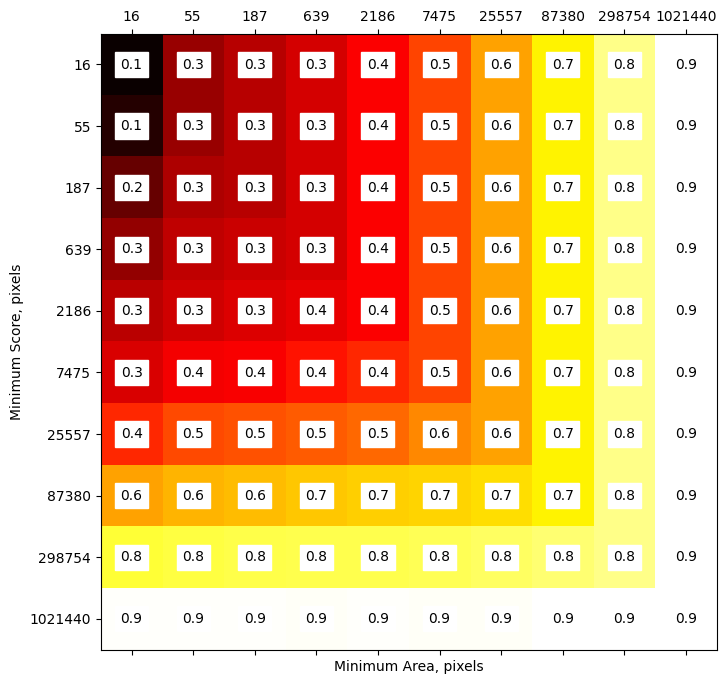

In [61]:
from matplotlib import pyplot as P

NUM_IMG = 1081.0

fig, ax = P.subplots()

data["score"] = data["score"].astype(np.int32)
data["area"] = data["area"].astype(np.int32)

num_dup = data["num_dup"].to_numpy()
num_dup = np.reshape(num_dup, (10, 10))
num_dup = num_dup / NUM_IMG

im = ax.matshow(num_dup, cmap="hot")
im.figure.set_size_inches((8, 8))
im.axes.set_yticks(range(10), labels=np.round(scores).astype(np.int32))
im.axes.set_xticks(range(10), labels=np.round(areas).astype(np.int32))
im.axes.set_xlabel("Minimum Area, pixels")
im.axes.set_ylabel("Minimum Score, pixels")


for (i, j), dups in np.ndenumerate(num_dup):
    ax.text(
        j, i,
        "{:.1f}".format(dups), ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="1"),
    )

Since we don't clearly know the expectation of what balance of change size vs. number of duplicates we want to maintain. We could choose parameters that define 50% of images beign removed.